# How to identify time-variable background noise ("rolling bands")?

In the previous tutorial we looked at making custom apertures to check planet signals. In this tutorial we will use the same technique to find variable background (such as rolling band signal) in Kepler data.

The background flux level of Kepler pixel data is not static. In particular, certain CCD channels occasionally experience the 'rolling band' effect, where the background has a strong time varying component of a 'band' moving up the detector (the band is the horizontal dark line that is approxmiately 30 pixels wide). You can read more about rolling band in the [Kepler Instrument Handbook](https://archive.stsci.edu/kepler/manuals/KSCI-19033-001.pdf). An example of the rolling band artifact is shown in the video below. You can see the band move through the superstamp at the 2 second mark, leaving the bottom of the screen at the 6 second mark.

![](rollingband.gif)

The rolling band artifact is small, up to about 20 counts per pixel. However, this signal can add up to significant levels for large apertures containing many pixels or for faint, quiet targets.

Rolling band can often add spurious signals into your data which look like real astrophysical variability. The best way to spot rolling band is to vary your aperture size. If the signal strength increases as you increase the number of background pixels in the aperture, the effect is likely to be an additive background component.

Below we will show you how to check for rolling band. First let's import `lightkurve` and download a target.

In [1]:
from lightkurve import search_targetpixelfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tpf = search_targetpixelfile('KIC 7691027', quarter=16).download()

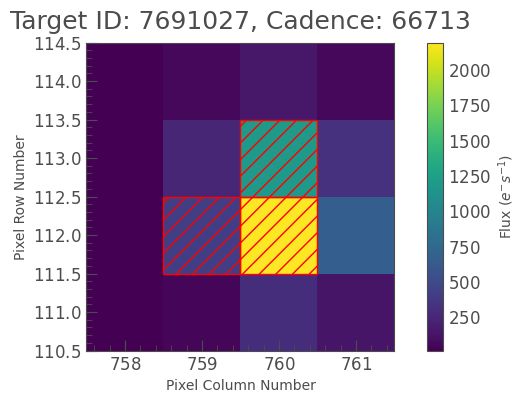

In [3]:
tpf.plot(aperture_mask=tpf.pipeline_mask);

This looks like a fairly normal Target Pixel File. Let's take a look at the light curve.

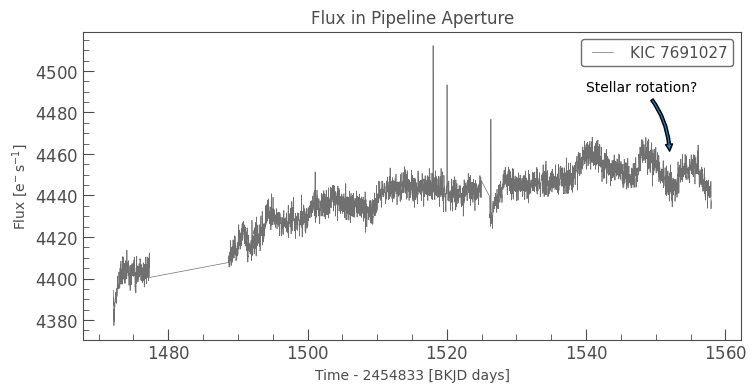

In [4]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

ax = lc.remove_outliers().plot(normalize=False, alpha=0.7)
ax.set_title('Flux in Pipeline Aperture')

ann = ax.annotate("Stellar rotation?",
                  xy=(1552, 4460), xycoords='data',
                  xytext=(1540, 4490), textcoords='data',
                  arrowprops=dict(arrowstyle="simple",
                                  connectionstyle="arc3, rad=-0.2"))

It looks like there are some features at around 1540 days that could be due to rotation in the star. But this could also be due to rolling band. Let's change the aperture of the target pixel file to **only include background pixels** and see if this signal is still present.

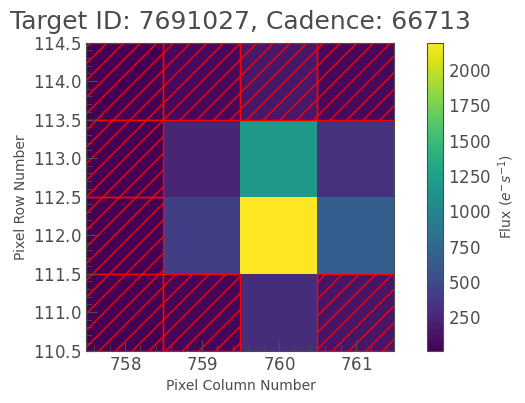

In [5]:
aperture = tpf.flux[0].value < 200
npix = len(np.where(aperture == True)[0])
tpf.plot(aperture_mask=aperture);

The mask avoids the center pixels. Let's create a light curve the same way as above. However, this time we're going to divide by the number of pixels in the aperture to give the the **average background flux per pixel.**

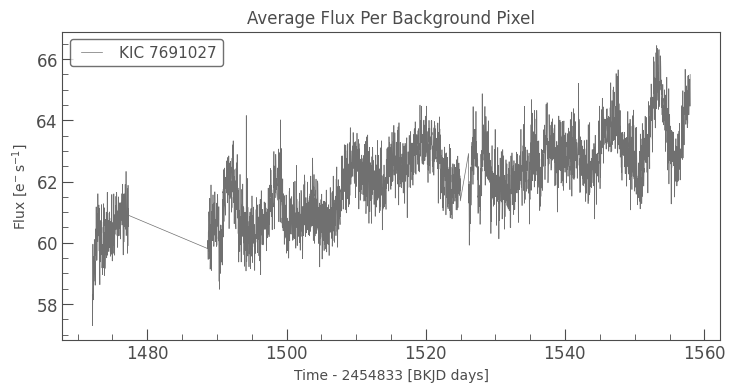

In [6]:
bkg_lc = tpf.to_lightcurve(aperture_mask=aperture)
bkg_lc /= npix  # Convert to electrons per second per pixel

ax = bkg_lc.remove_outliers().plot(normalize=False, alpha=0.7)
ax.set_title('Average Flux Per Background Pixel');

It looks like the signal is still there in the background pixels. Unfortunately this means the signal is not astrophysical.

We can perform another test by looking at the background in a nearby source. Using the [search_targetpixelfile](https://docs.lightkurve.org/reference/api/lightkurve.search_targetpixelfile.html?highlight=search_targetpixelfile) function we can get the nearest neighbor to our target. We first set a search radius in arcseconds and a limit on the number of targets to return. In this case we only want our target and the nearest neighbour within 60 arcseconds, so we'll set `radius` to 60 and `limit` to 2 targets.

In [7]:
tpfs = search_targetpixelfile('KIC 7691027', radius=60, quarter=16, limit=2).download_all()

In [8]:
tpfs

TargetPixelFileCollection of 2 objects:
    0: KeplerTargetPixelFile Object (ID: 7691027)
    1: KeplerTargetPixelFile Object (ID: 7691061)

Now we can see that `tpfs` is a list of [KeplerTargetPixelFile](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.html?highlight=keplertargetpixelfile) objects. There are two different object IDs, our target and the nearest neighbour.

Let's double check that these target pixel files are close to each other

In [9]:
separation = np.sqrt((tpfs[0].column - tpfs[1].column)**2 + (tpfs[0].row - tpfs[1].row)**2)
print('TPFs are {:.02} Pixels Apart'.format(separation))

TPFs are 9.5 Pixels Apart


Since these are files are very close on the focal plane, we would expect them to experience similar levels of background. We can now perform the same test as above and look at the background flux averaged over all the background pixels. We'll do this inside a for loop and follow the same steps:
* Build the aperture
* Create the light curve (`KeplerLightCurve` object)
* Plot the light curve

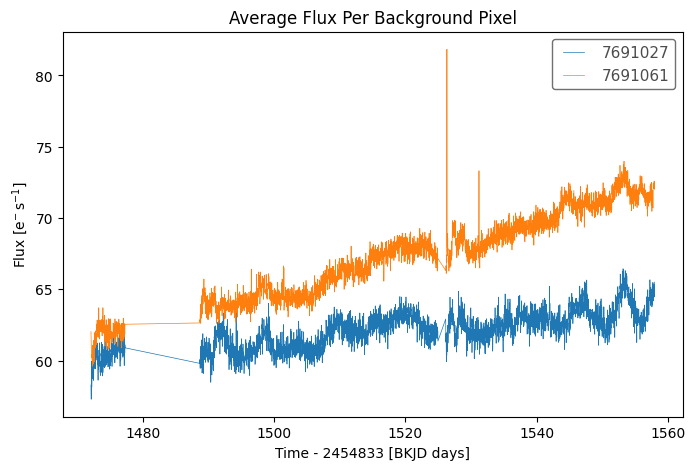

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
for t in tpfs.data:
    # Construct a background aperture
    aper = np.nan_to_num(t.flux[0].value) < 200
    npix = len(np.where(aper == True)[0])
    
    # Create a lightcurve
    bkg_lc = t.to_lightcurve(aperture_mask=aper)
    bkg_lc /= npix  # Don't forget to normalize by the number of pixels in the aperture!

    # Plot the result
    bkg_lc = bkg_lc.remove_outliers()
    bkg_lc.plot(ax=ax, normalize=False, label=t.targetid)

ax.set_title('Average Flux Per Background Pixel');

Looks like a nearby source shows quite similar background variation. This suggests that unfortunately the signal is rolling band. Mitigating rolling band can be difficult, and we'll discuss corrections in a different tutorial.